In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from tqdm import tqdm
from numpy import array
import sys
sys.path.append("..")
from core.utils import *
import atlas_mpl_style as ampl
import random
import mplhep as hep
hep.style.use("ATLAS")
import random

pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots'
#pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new_hrzhao'#note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'

In [14]:
reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600, 800, 1000, 1200, 1500]
bin_centers = 0.5 * (np.array(label_ptrange[:-1]) + np.array(label_ptrange[1:]))
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT"
}
HistBins = {
    'jet_pt' : np.linspace(500, 2000, 61),
    'jet_eta' : np.linspace(-2.5, 2.5, 51), 
    'jet_nTracks' : np.linspace(0, 60, 61),
    'jet_trackWidth' : np.linspace(0, 0.4, 61),
    'jet_trackC1' : np.linspace(0, 0.4, 61),
    'jet_trackBDT' : np.linspace(-1.0, 1.0, 101),
    #'GBDT_newScore' : np.linspace(-2.0, 2.0, 51),
    'GBDT_newScore' : np.linspace(-5.0, 5.0, 101),
    #'GBDT_newScore' : np.linspace(0, 1.0, 51),
}

Map_gen={
"nominal": "Pythia",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia",
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [4]:
def Plot_ROC(Extraction_Results, output_path,vars):
    swaped_Extraction_Results = {}
    label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
    #label_var = ['jet_nTracks']#, 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
    
    var = vars[0]

    for syst in Extraction_Results.keys():
        swaped_Extraction_Results[syst]={}
        label_keys = [*Extraction_Results[syst]['jet_nTracks'][500]] 
        for l_ptrange in label_ptrange[:-1]:
            swaped_Extraction_Results[syst][l_ptrange] = {}
            for l_key in label_keys:
                swaped_Extraction_Results[syst][l_ptrange][l_key] = {}
                for l_var in vars:
                    swaped_Extraction_Results[syst][l_ptrange][l_key][l_var] = Extraction_Results[syst][l_var][l_ptrange][l_key]
        output_path_new = output_path
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True, exist_ok =True)

    eta_regions = {
        "ForwardandCentral": ['p_Quark', 'p_Gluon'],
        "Forward": ['p_Forward_Quark', 'p_Forward_Gluon'],
        "Central": ['p_Central_Quark', 'p_Central_Gluon']
    }
    lines=['o','v','3','d','p','x','*','s']
    for k, v in eta_regions.items():
        for i_pt, pt in enumerate(label_ptrange[:-1]):
            fig, ax0 = plt.subplots()
            for syst in Extraction_Results.keys():
                two_vars = swaped_Extraction_Results[syst][l_ptrange]
                p_Quark_unumpy = two_vars[v[0]]
                p_Gluon_unumpy = two_vars[v[1]]
                aucc={}
                p_Quark = unumpy.nominal_values(p_Quark_unumpy[var])
                p_Gluon = unumpy.nominal_values(p_Gluon_unumpy[var])
                var_bins = HistBins[var]
                n_cut = len(var_bins)-1
                quark_effs = np.zeros(n_cut)
                gluon_rejs = np.zeros(n_cut)
                TPR = np.zeros(n_cut)
                FPR = np.zeros(n_cut)

                for cut_idx in range(n_cut):
                    TP = np.sum(p_Quark[:cut_idx])
                    TN = np.sum(p_Gluon[cut_idx:])
                    FP = np.sum(p_Gluon[:cut_idx])
                    FN = np.sum(p_Quark[cut_idx:])
                    TPR[cut_idx] = TP/(TP+FN) 
                    FPR[cut_idx] = FP/(FP+TN)
                    quark_effs[cut_idx] = TP ## After normalization 
                    gluon_rejs[cut_idx] = TN

                #aucc[syst]=auc(FPR,TPR) 
                ##print("gluon_rejs: ",gluon_rejs)
                i=list(Extraction_Results).index(syst)
                ax0.plot(quark_effs, gluon_rejs, label =f"{Map_gen[syst]}",marker=lines[i],markersize=5)#, AUC = %0.3f"%(aucc[syst])
            #hep.histplot(aucc,bins=label_ptrange,ax=ax0,histtype='errorbar',label = 'AUC')
            ax0.legend(loc='lower left')
            #ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
            ax0.text(0.05,0.8,f'{pt} - {label_ptrange[i_pt+1]} GeV {Map_var_title[var]}',fontsize=15)
            hep.atlas.label(label='Internal',ax=ax0,lumi=140,loc=2)
            ax0.set_xlabel("Quark Efficiency")
            ax0.set_ylabel("1 - Gluon Rejection")
    
            ax0.set_xlim(0,1)
            ax0.set_ylim(0,1)
        #ax0.text(0.2,0.2,f'{syst}')
            fig_name = output_path_new / f"AUC_{l_ptrange}_{k}_{var}_num.pdf"
            fig.savefig(fig_name)
    #plt.close()
            plt.show()
         


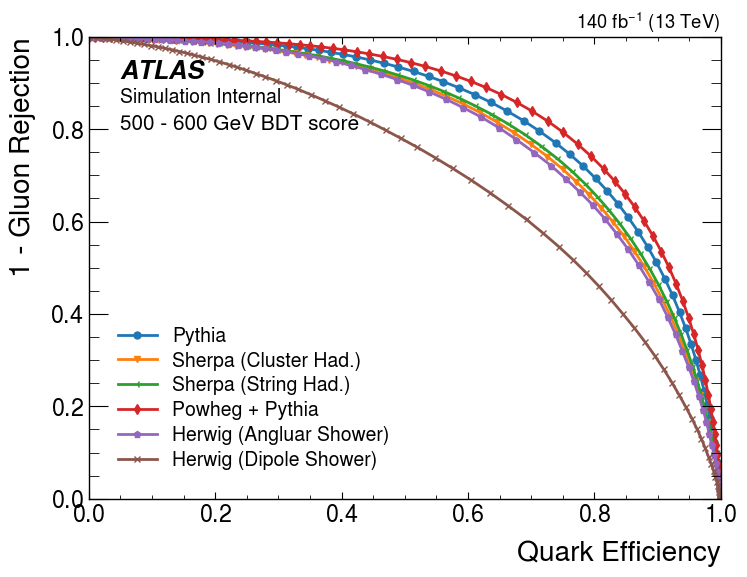

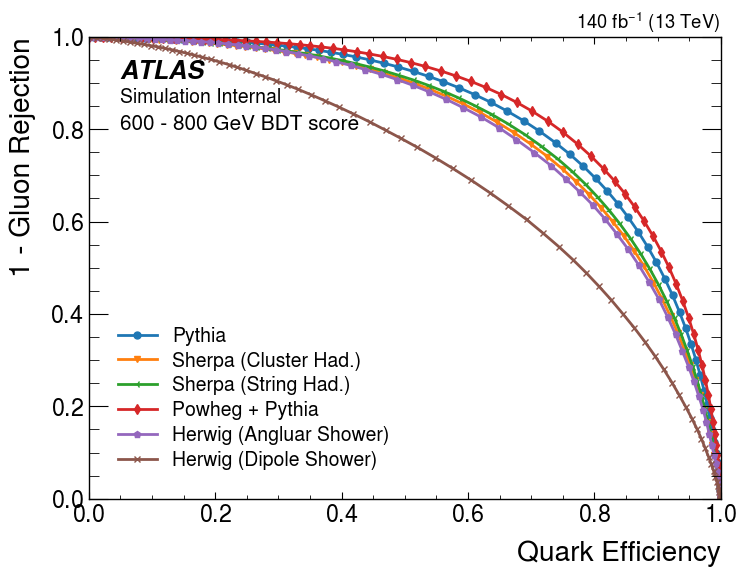

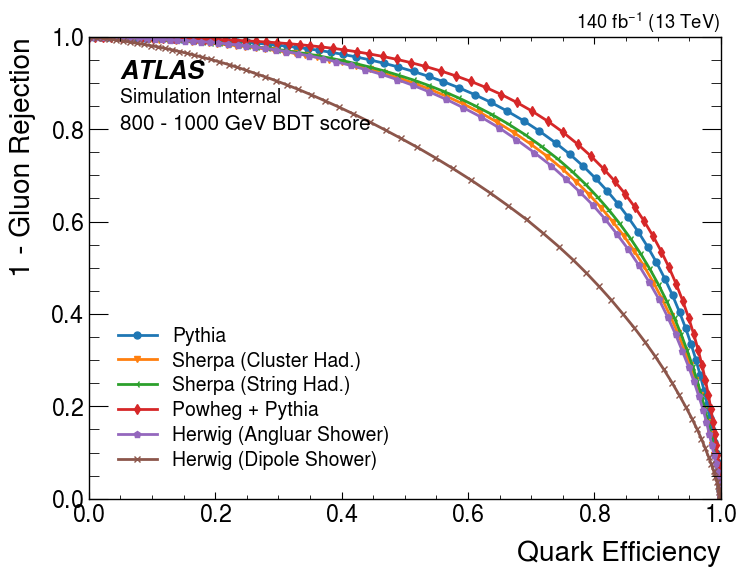

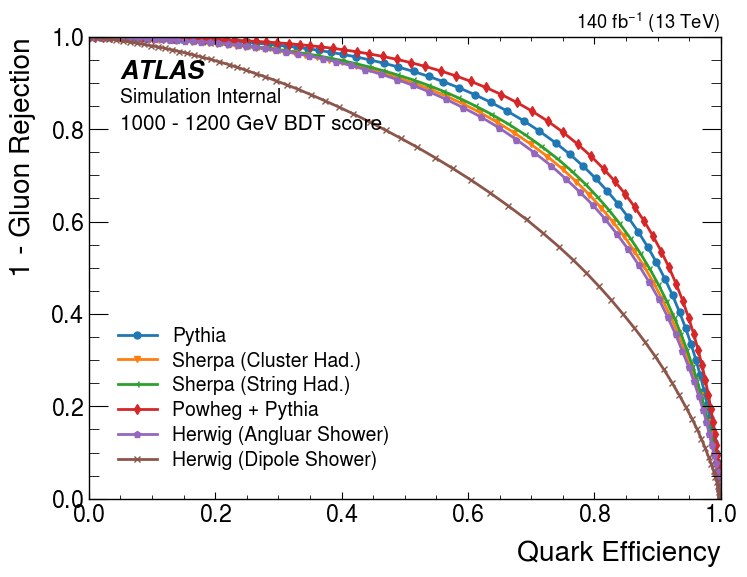

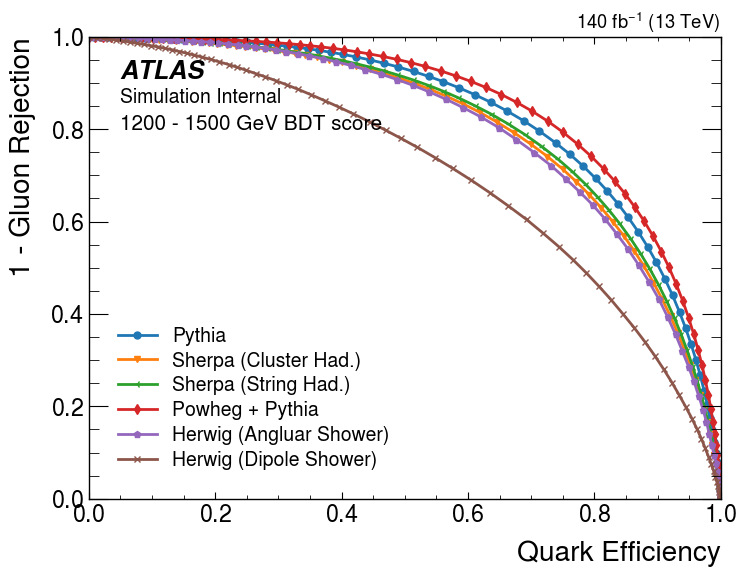

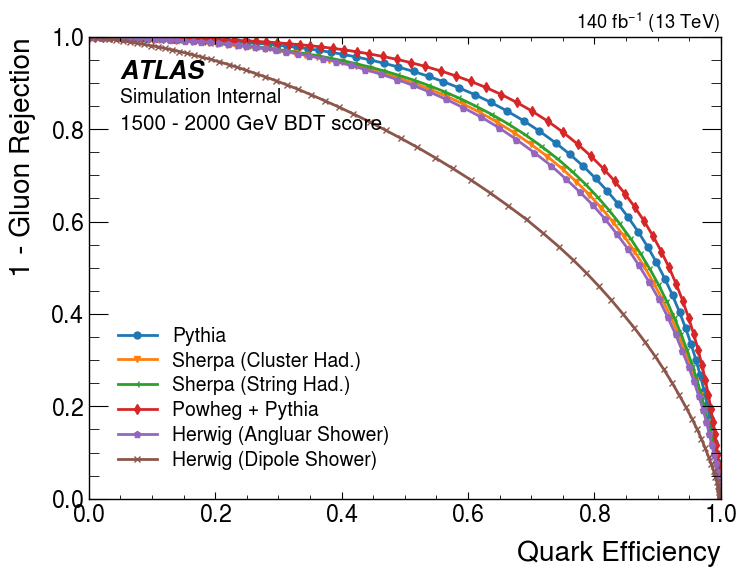

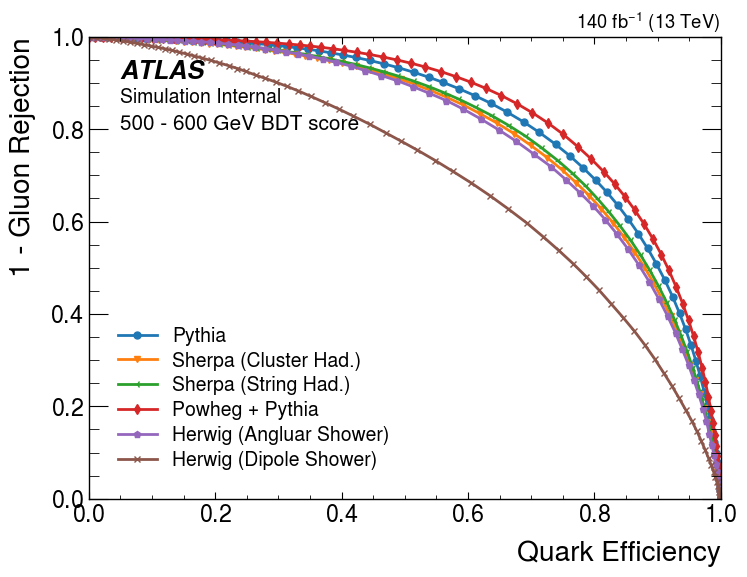

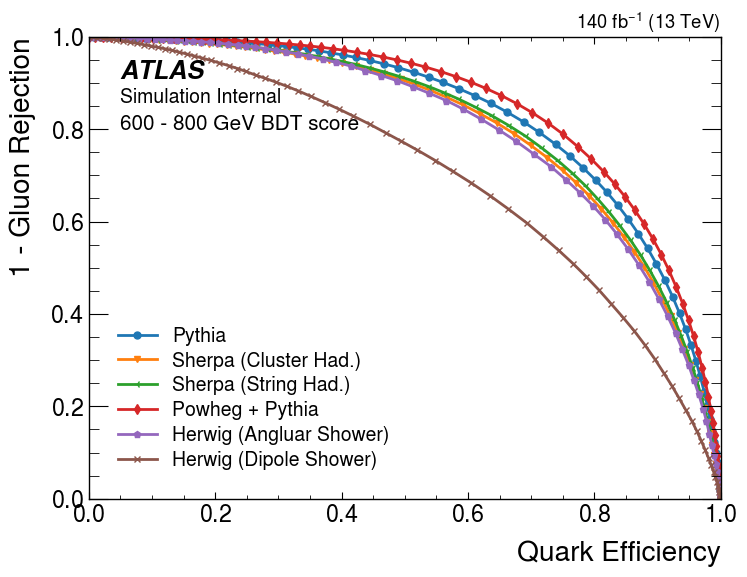

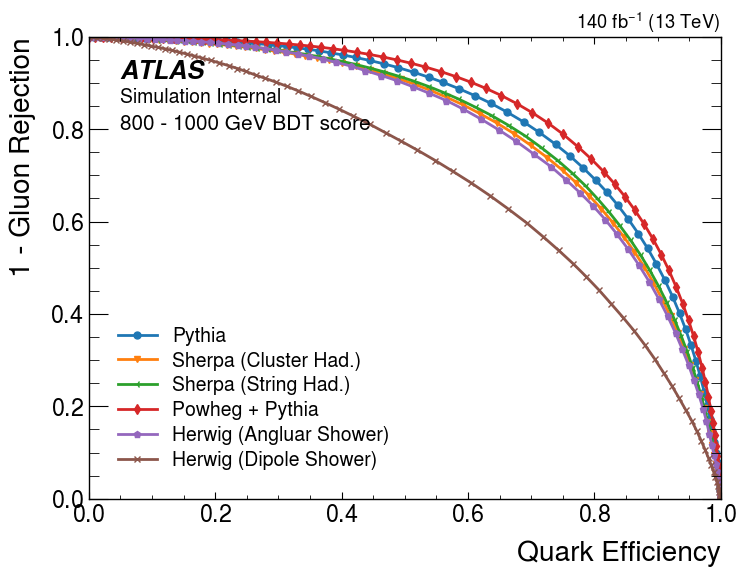

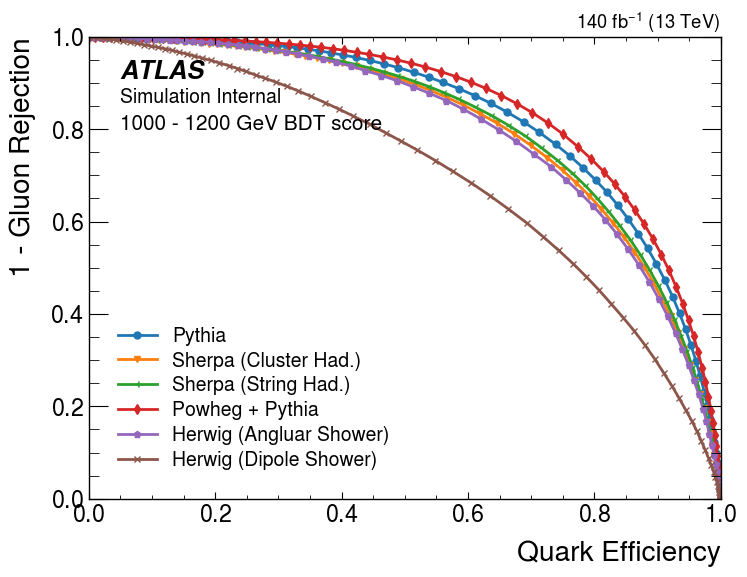

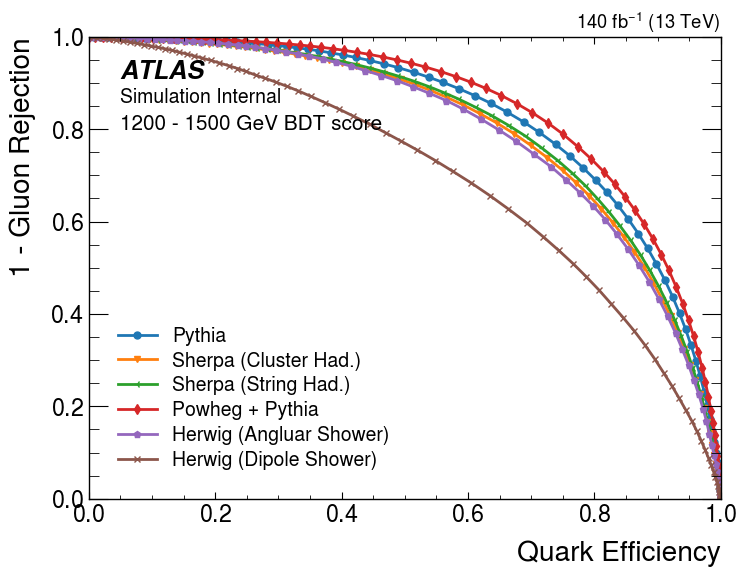

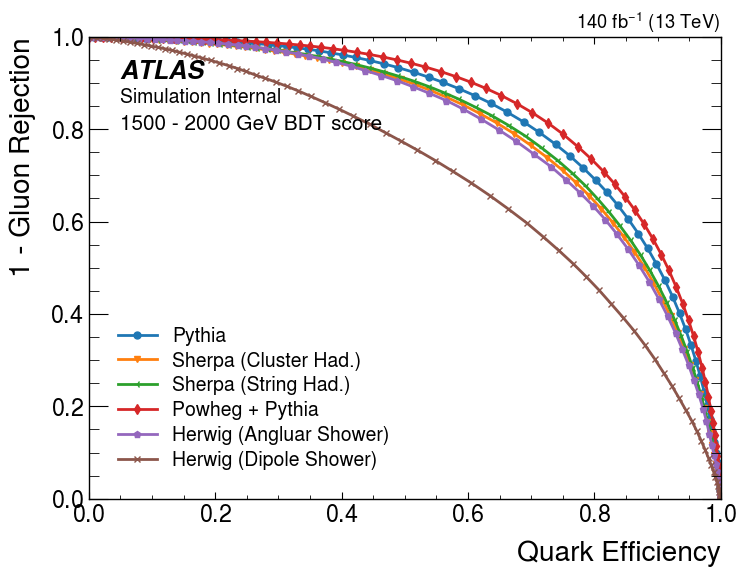

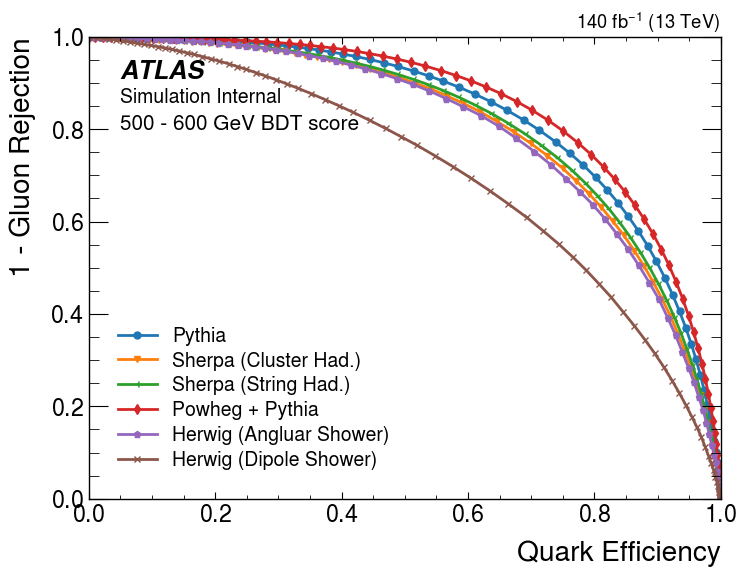

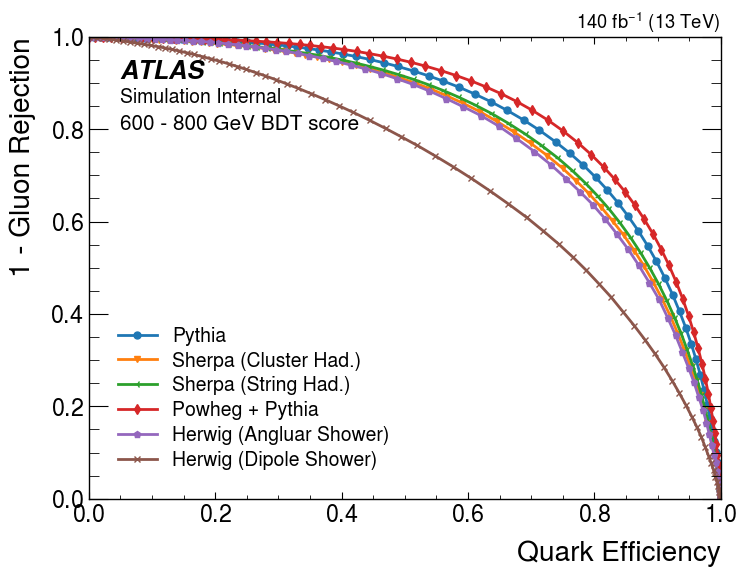

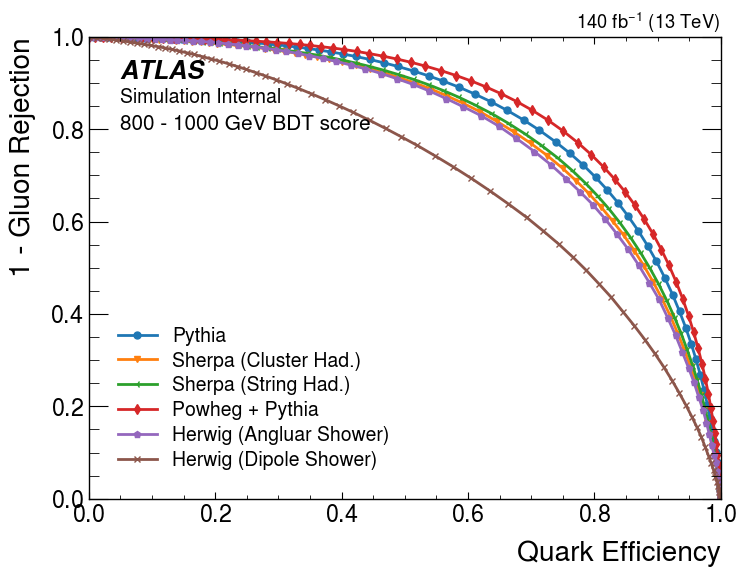

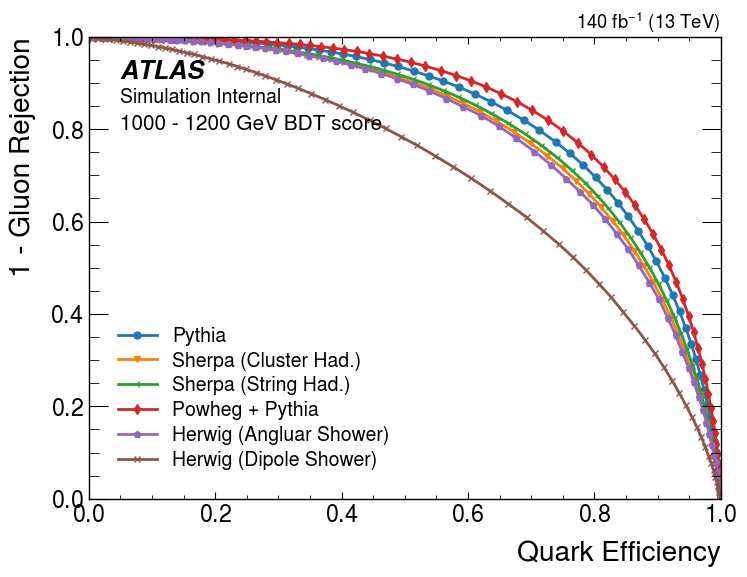

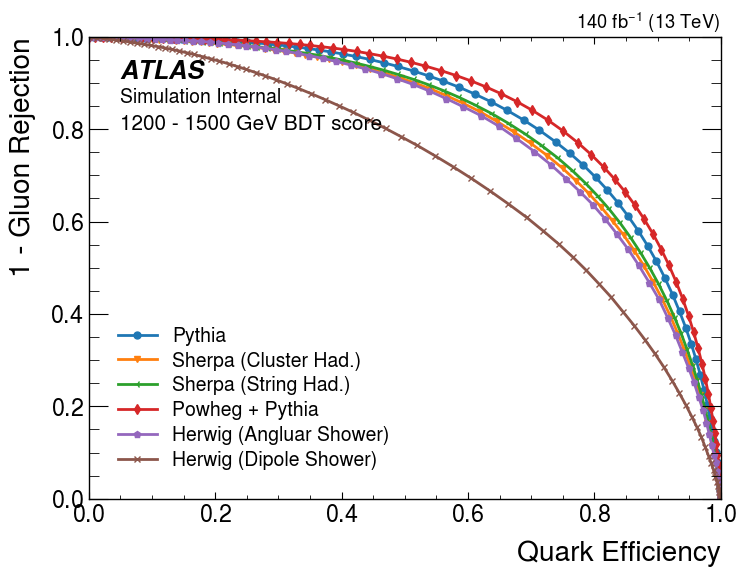

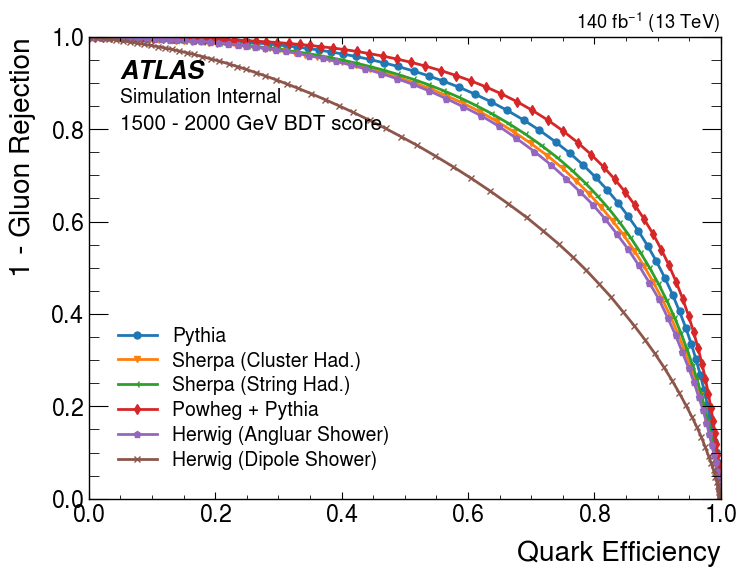

In [13]:
SFs = {}
Extraction_Results={}
#syst_list=['parton_shower/herwigangle']#,'parton_shower/herwigdipole']
syst_list=['nominal','hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for var in ['GBDT_newScore']:
    for i, syst in enumerate(syst_list):
            syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
            Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
    Plot_ROC(Extraction_Results, output_path=Path('../ROC'),vars=[f'{var}'])

In [33]:
def _Plot_ROC(p_Quark_unumpy, p_Gluon_unumpy, l_ptrange, etaregion,i_pt):
    label_var = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
    lines=['o','v','x','s','p','d','*']
    fig, ax0 = plt.subplots()
    aucc={}
    for i_var, l_var in enumerate(label_var):
        p_Quark = unumpy.nominal_values(p_Quark_unumpy[l_var])
        p_Gluon = unumpy.nominal_values(p_Gluon_unumpy[l_var])

        var_bins = HistBins[l_var]
        n_cut = len(var_bins)-1
        quark_effs = np.zeros(n_cut)
        gluon_rejs = np.zeros(n_cut)
        TPR = np.zeros(n_cut)
        FPR = np.zeros(n_cut)

        for cut_idx in range(n_cut):
            TP = np.sum(p_Quark[:cut_idx])
            TN = np.sum(p_Gluon[cut_idx:])
            #TN=1.0/np.sum(p_Gluon[:cut_idx])
            FP = np.sum(p_Gluon[:cut_idx])
            FN = np.sum(p_Quark[cut_idx:])
            #FN = 1.0/np.sum(p_Quark[:cut_idx])
            TPR[cut_idx] = TP/(TP+FN) 
            FPR[cut_idx] = FP/(FP+TN)
            quark_effs[cut_idx] = TP ## After normalization 
            gluon_rejs[cut_idx] = TN

        aucc[l_var]=auc(FPR,TPR) 
        ax0.plot(quark_effs, gluon_rejs, label = f"{Map_var_title[l_var]}, AUC = %0.3f"%(aucc[l_var]),marker=lines[i_var],markersize=7)
    ax0.text(0.05,0.8,'anti-$k_{t}$ R=0.4 PFlow jet',fontsize=15)
    ax0.text(0.05,0.73,'Quark-jet tagging',fontsize=15)
    ax0.text(0.05,0.66,f'{l_ptrange} < '+ r'$p_{\mathrm{T}}$'+ f' < {label_ptrange[i_pt+1]} GeV',fontsize=15)

        #hep.histplot(quark_effs,gluon_rejs,ax=ax0,label = f"{Map_var_title[l_var]}",histtype='step',linstyle=lines[i_var])
        

    #ax0.set_title(f"ROC for truth q/g at {l_ptrange} GeV, {etaregion}")
    ax0.set_xlabel("Quark Efficiency")
    ax0.set_ylabel("1 - Gluon Rejection")
    
    #ax0.set_xticks(np.linspace(0, 1, 11))
    ax0.set_xlim(0,1)
    #ax0.set_yticks(np.linspace(0, 1, 21))
    ax0.set_ylim(0,1)
    ax0.legend()
    #ax0.grid()
    hep.atlas.label(label='Internal',ax=ax0,loc=2)

    return fig


def Plot_ROC(Extraction_Results, output_path,vars):
    swaped_Extraction_Results = {}
    label_ptrange = [500, 600]#, 800, 1000, 1200, 1500, 2000]
    label_var = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1', 'GBDT_newScore']
    label_keys = [*Extraction_Results['jet_nTracks'][500]]
    for l_ptrange in label_ptrange[:-1]:
        swaped_Extraction_Results[l_ptrange] = {}
        for l_key in label_keys:
            swaped_Extraction_Results[l_ptrange][l_key] = {}
            for l_var in label_var:
                swaped_Extraction_Results[l_ptrange][l_key][l_var] = Extraction_Results[l_var][l_ptrange][l_key]

    if not output_path.exists():
        output_path.mkdir(parents = True, exist_ok =True)

    eta_regions = {
        "ForwardandCentral": ['p_Quark', 'p_Gluon'],
        "Forward": ['p_Forward_Quark', 'p_Forward_Gluon'],
        "Central": ['p_Central_Quark', 'p_Central_Gluon']
    }
    for k, v in eta_regions.items():
        for i_pt,l_ptrange in enumerate(label_ptrange[:-1]):
            two_vars = swaped_Extraction_Results[l_ptrange]
            fig = _Plot_ROC(p_Quark_unumpy = two_vars[v[0]], p_Gluon_unumpy = two_vars[v[1]],
                            l_ptrange=l_ptrange, etaregion=k, i_pt=i_pt)
            fig_name = output_path / f"ROC_{l_ptrange}_{k}_{vars}.pdf"
            fig.savefig(fig_name)
            #print(f"pt: ,{l_ptrange}")

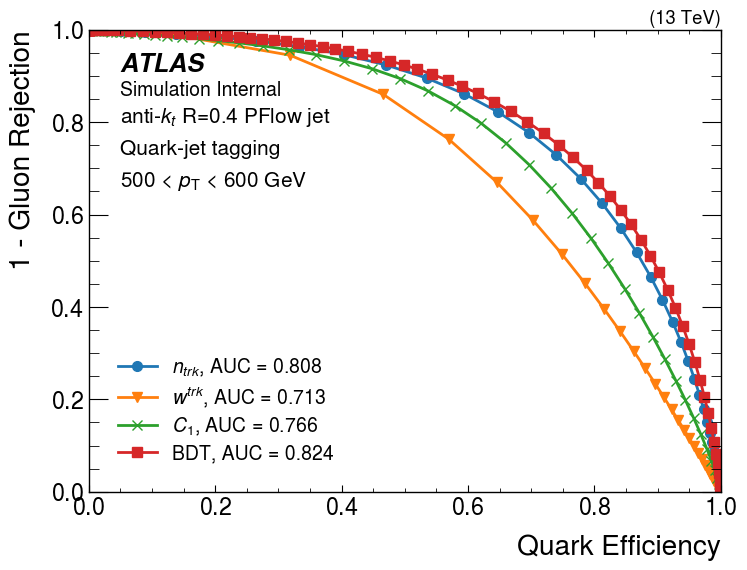

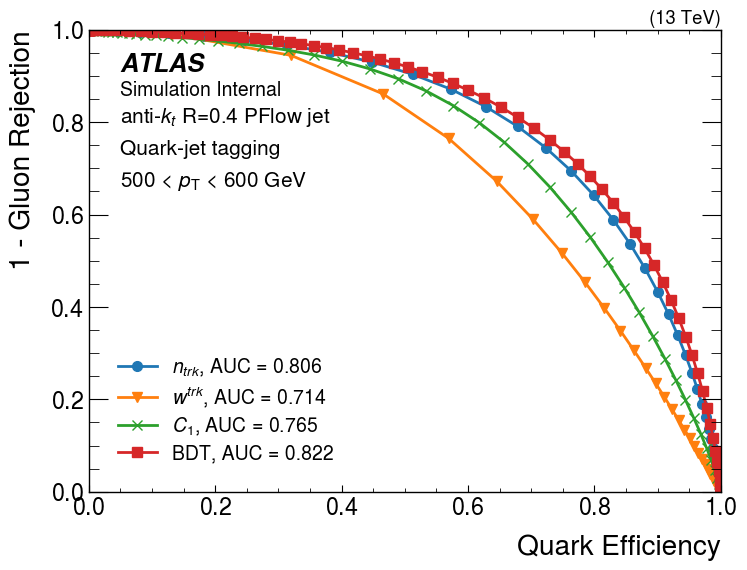

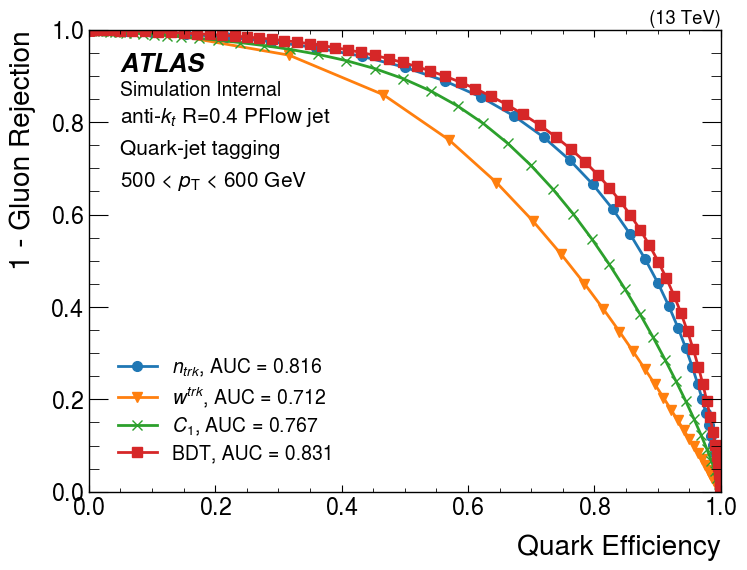

In [34]:
for var in ['none']:#,'jet_nTracks','GBDT_newScore']:
   
        syst_path= pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'
        Extraction_Results= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
Plot_ROC(Extraction_Results, output_path=Path('../ROC'),vars=var)

AUC as a function of jet pt

In [26]:
def Plot_AUC(Extraction_Results, output_path):
    swaped_Extraction_Results = {}
    label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
    vars = ['jet_nTracks', 'GBDT_newScore']
    

    for syst in Extraction_Results.keys():
        swaped_Extraction_Results[syst]={}
        label_keys = [*Extraction_Results[syst]['jet_nTracks'][500]]
        for l_ptrange in label_ptrange[:-1]:
            swaped_Extraction_Results[syst][l_ptrange] = {}
            for l_key in label_keys:
                swaped_Extraction_Results[syst][l_ptrange][l_key] = {}
                for l_var in vars:
                    swaped_Extraction_Results[syst][l_ptrange][l_key][l_var] = Extraction_Results[syst][l_var][l_ptrange][l_key]
        output_path_new = output_path
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True, exist_ok =True)

    eta_regions = {
        "ForwardandCentral": ['p_Quark', 'p_Gluon'],
        "Forward": ['p_Forward_Quark', 'p_Forward_Gluon'],
        "Central": ['p_Central_Quark', 'p_Central_Gluon']
    }
    lines=['o','s','3','d','p','x','*','^']
    for k, v in eta_regions.items():
        fig, ax0 = plt.subplots()
        aucc={}
        for var in vars:
            aulist=[]
            for l_ptrange in label_ptrange[:-1]:
            #for syst in Extraction_Results.keys():
                two_vars = swaped_Extraction_Results[syst][l_ptrange]
                p_Quark_unumpy = two_vars[v[0]]
                p_Gluon_unumpy = two_vars[v[1]]
               
                #var = vars[0]
                p_Quark = unumpy.nominal_values(p_Quark_unumpy[var])
                p_Gluon = unumpy.nominal_values(p_Gluon_unumpy[var])

                var_bins = HistBins[var]
                n_cut = len(var_bins)-1
                quark_effs = np.zeros(n_cut)
                gluon_rejs = np.zeros(n_cut)
                TPR = np.zeros(n_cut)
                FPR = np.zeros(n_cut)

                for cut_idx in range(n_cut):
                    TP = np.sum(p_Quark[:cut_idx])
                    TN = np.sum(p_Gluon[cut_idx:])
                    FP = np.sum(p_Gluon[:cut_idx])
                    FN = np.sum(p_Quark[cut_idx:])
                    TPR[cut_idx] = TP/(TP+FN) 
                    FPR[cut_idx] = FP/(FP+TN)
                    quark_effs[cut_idx] = TP ## After normalization 
                    gluon_rejs[cut_idx] = TN

                aulist.append(auc(FPR,TPR))
                
            aucc[var]=aulist
            i=vars.index(var)
            colors='b'
            if var == 'GBDT_newScore':
                colors = 'red'
                #ax0.plot(aucc[syst], label_ptrange, label =f"{Map_var_title[var]},{Map_gen[syst]}, AUC = %0.3f"%(aucc[syst]),marker=lines[i],markersize=5)
            hep.histplot(aucc[var],bins=label_ptrange,ax=ax0,histtype='errorbar',label = f"{Map_var_title[var]}",xerr=True,yerr=0.00001,marker=lines[i],markersize=10,color=colors)
        
        ax0.legend(loc='lower left',fontsize=18)
        hep.sort_legend(ax=ax0)
        ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
        hep.atlas.label(label='Internal',ax=ax0)
        ax0.set_xlabel("$p_{\mathrm{T}}$ [GeV]")
        ax0.set_ylabel("AUC")

        ax0.set_ylim(0.7,0.95)
        #ax0.text(580,0.9,'Pythia',fontsize=15)
        ax0.text(580,0.899,'anti-$k_{t}$ R=0.4 PFlow jet',fontsize=15)
        ax0.text(580,0.88,'Quark-jet tagging',fontsize=15)
    #ax0.text(0.2,0.2,f'{syst}')
        fig_name = output_path_new / f"pt_{k}_{var}.pdf"
        fig.savefig(fig_name)
#plt.close()
        plt.show()
         


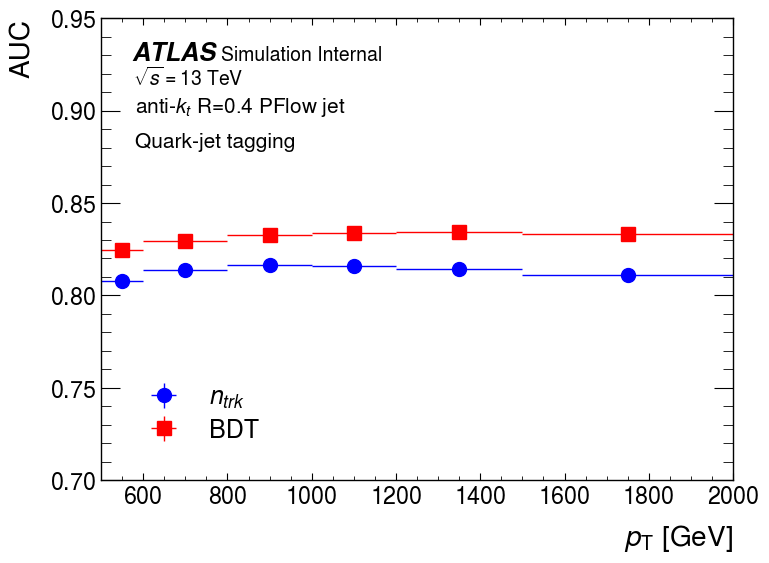

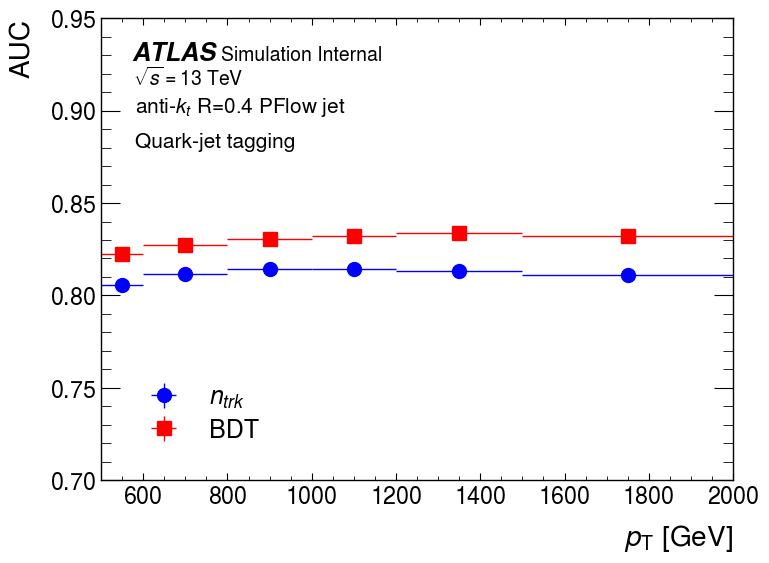

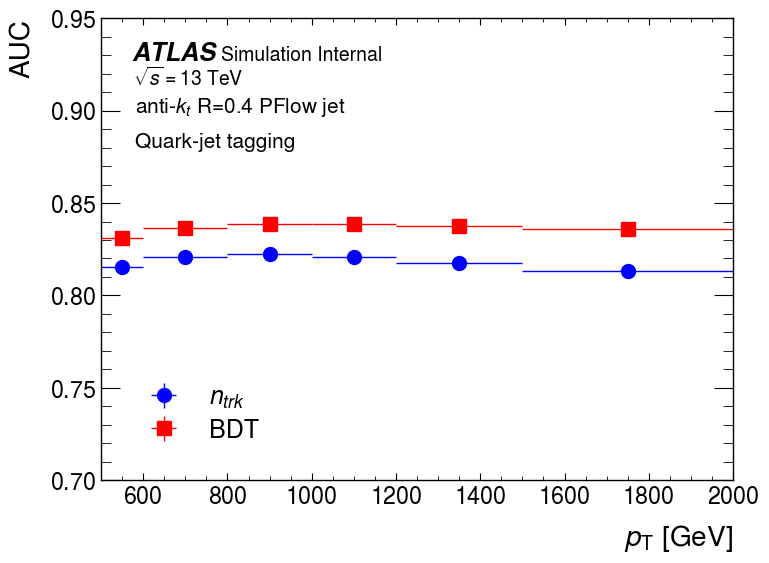

In [28]:
SFs = {}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']


for var in ['none']:
    for i, syst in enumerate(syst_list):
            syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'
            Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
            
    Plot_AUC(Extraction_Results, output_path=Path('../ROC'))